## Exploratory notebook 

- I. Univariate analysis : the nutrition score and grade

- II. Bivariate analysis : fat and nutrition grade 

- III. Multivariate analysis and dimension reduction

- IV. Application output 


In [58]:
import pandas as pd
import scipy.stats as st
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.ticker import PercentFormatter
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [59]:
# load dataset than has been clean in the cleanUp notebook 
clean_data = pd.read_csv('clean_data.csv')

In [60]:
clean_data.head(2)


,product_name,additives_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,calcium_100g,trans-fat_100g,iron_100g,cholesterol_100g,fiber_100g
0,Lion Peanut x2,1.0,e,1883.0,20.0,12.5,70.0,57.5,2.5,0.09652,0.038000,22.0,0.10,0.0,0.0009,0.012,2.5
1,Financiers aux Amandes,3.0,e,1868.0,23.0,10.0,51.0,39.0,8.0,0.55000,0.216535,22.0,0.13,0.0,0.0053,0.000,1.7


Here we notice that there are 17 variables left after the cleaning.

14 of them are qualitative continuous variables between 0 and 100 (g). 

##  Univariate analysis
## The nutrition grade (nutriscore)   : discrete qualitative ordinal variable 
The grade goes from A to E, A being the most interesting product regarding nutrition.

It takes into account nutriments that benefit the health such as fiber, proteins and the one harmful in too large quantity such as saturated fat, sugar or salt. 

Therefore, this grade **is a key variable** for my project. We will look at its distribution over our dataset.

In [61]:
# count each modalities occurrence 
counts = clean_data["nutrition_grade_fr"].value_counts()
# display each modality 
print("Modalities of nutrition_grade_fr variables are : ",counts.index.tolist())

# Table of cumulative frequency : 
tab = pd.DataFrame(counts, columns = ["nutrition_grade_fr"])
tab = tab.sort_values("nutrition_grade_fr",ascending=False)
tab["frequency"] = tab["nutrition_grade_fr"] / len( clean_data["nutrition_grade_fr"])
tab["ascending_cumulative_frequency"] =  tab["frequency"].cumsum()

print("Nutriscore mode (most represented value) is  : \t", tab.head(1).index[0])

print("\nCumulative frequency table of  nutrition_grade_fr")
display(tab)

Modalities of nutrition_grade_fr variables are :  ['a', 'd', 'c', 'b', 'e']
Nutriscore mode (most represented value) is  : 	 a

Cumulative frequency table of  nutrition_grade_fr


,nutrition_grade_fr,frequency,ascending_cumulative_frequency
a,6303,0.249614,0.249614
d,5781,0.228941,0.478555
c,5586,0.221219,0.699774
b,4180,0.165538,0.865312
e,3392,0.134331,0.999644


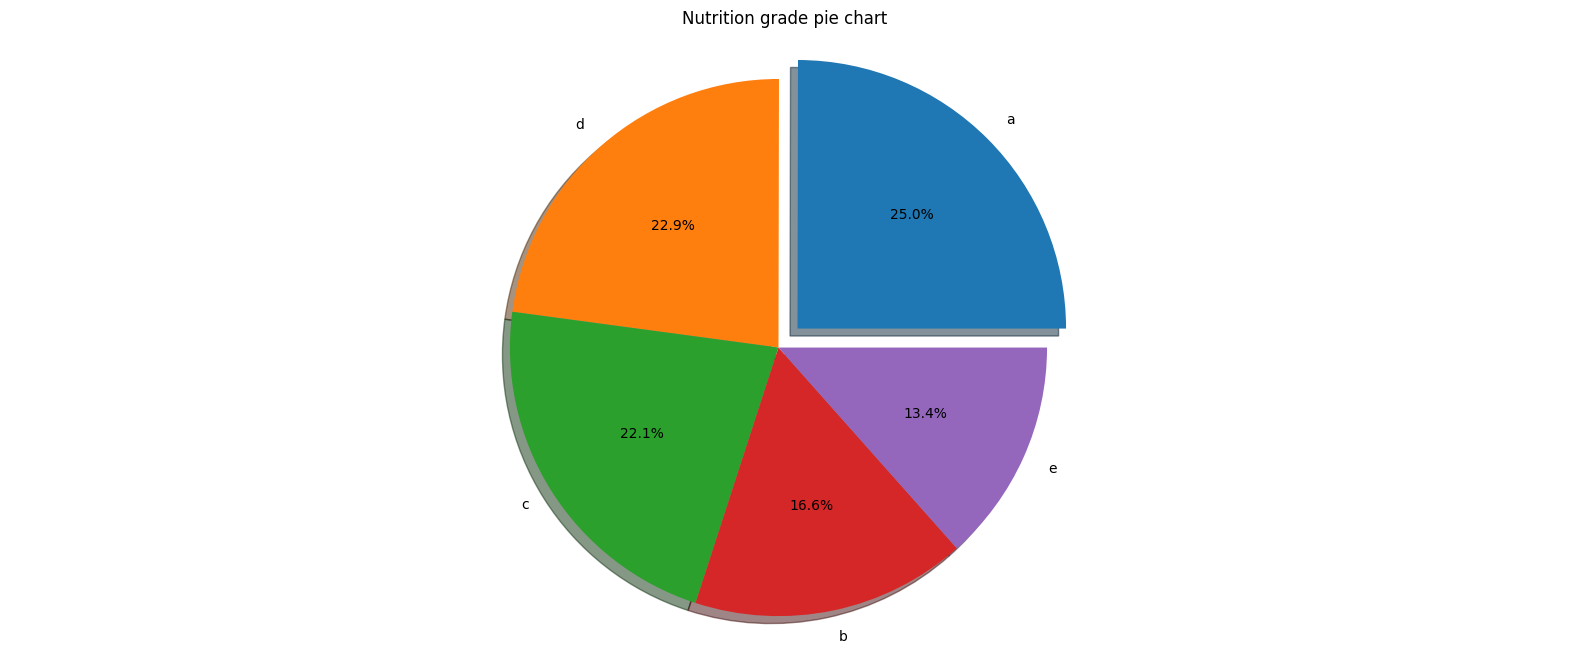

In [62]:
fig1, ax1 = plt.subplots()
explode = (0.1, 0, 0, 0,0) 
ax1.pie( tab["frequency"],
            labels = tab.index, # a, b c ...
            shadow=True, # add grey shadow 
            autopct='%1.1f%%', # add auto-labeling percentage
            explode=explode # angle the mode 
        )
ax1.set_title("Nutrition grade pie chart")
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The nutriscore grade is correlated with the nutrition score. 

However the nutrition grade cannot be computed from the nutrition score as it does not correspond strictly to different intervals.  

Text(0, 0.5, 'nutrition-score (g)')

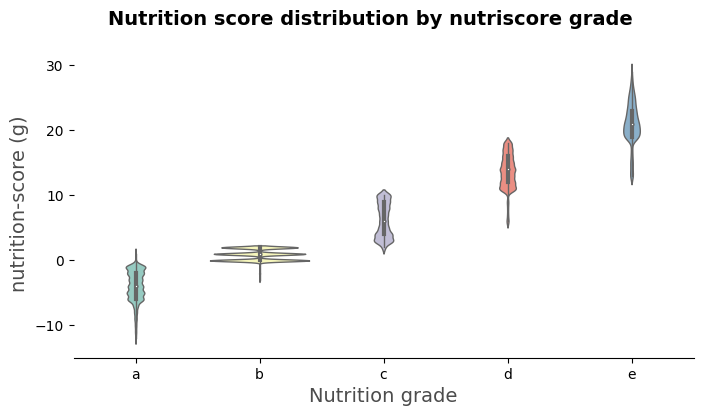

In [63]:
# Violin plot : 
f, ax = plt.subplots(figsize=(8, 4))

# Show each distribution with both violins and points
sns.violinplot(x="nutrition_grade_fr",y="nutrition-score-fr_100g",data=clean_data, \
    inner="box", palette="Set3", cut=2, linewidth=1,order=['a','b','c','d','e'])

sns.despine(left=True)

f.suptitle('Nutrition score distribution by nutriscore grade ', fontsize=14, fontweight='bold')
ax.set_xlabel("Nutrition grade",size = 14,alpha=0.7)
ax.set_ylabel("nutrition-score (g)",size = 14,alpha=0.7)

## Bivariate Analysis : Fat and nutriscore
As the nutrition grade is linked to all nutriments, I would like to study in details the link between fat and nutriscore thanks to a bivariate study. I was wondering : 
- Is there a difference between the amount of fat of two products with different nutrition grade ? 
- If yes, what is this difference between these products ? 

In [64]:
pearson_coefficient = st.pearsonr(clean_data["fat_100g"],clean_data["nutrition-score-fr_100g"])[0]

print("Pearson's  coefficient: " ,round(pearson_coefficient,10))

if pearson_coefficient > 0.99 : 
    print("Positive linear correlation between fat and nutrition-score.")
if pearson_coefficient > 0 : 
    print("Positive correlation between fat and nutrition-score.")
elif pearson_coefficient == 0 :
    print("No correlation between fat and nutrition-score.")
elif ( pearson_coefficient < 0 ) & ( pearson_coefficient > -1 ):
    print("Negative correlation between fat and nutrition-score.")
else : 
    print("Cannot deduce link between two variables")

Pearson's  coefficient:  0.7090755653
Positive correlation between fat and nutrition-score.


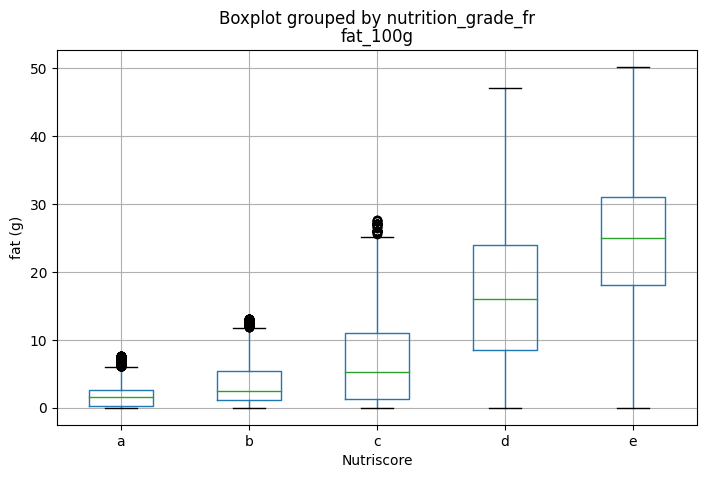

In [65]:
# Compute median of saturated-fat_100g for each fat quantiles 
groups = clean_data.groupby('nutrition_grade_fr')["fat_100g"]

# Clean up : interquartile upper and lower limit : 
Q1s = groups.quantile(0.25)
Q3s = groups.quantile(0.75)
IQRs = Q3s - Q1s # interquartile range (the size of the box in the boxplot)
Lowers = Q1s - 1.5*IQRs
Uppers = Q3s + 1.5*IQRs

plt.rcParams["figure.figsize"] = [8.00, 5.00] 
nutriscores = Q1s.index.values
for nutriscore in nutriscores : 
    mask =  ( clean_data['nutrition_grade_fr'] == nutriscore ) & (( (clean_data["fat_100g"] >= Uppers[nutriscore] ) | ( clean_data["fat_100g"] <= Lowers[nutriscore] )) )
    clean_data.drop(clean_data.loc[mask].index, inplace=True)
boxplot = clean_data.boxplot('fat_100g', by='nutrition_grade_fr')
boxplot.set_xlabel('Nutriscore')
boxplot.set_ylabel('fat (g)')
plt.show()


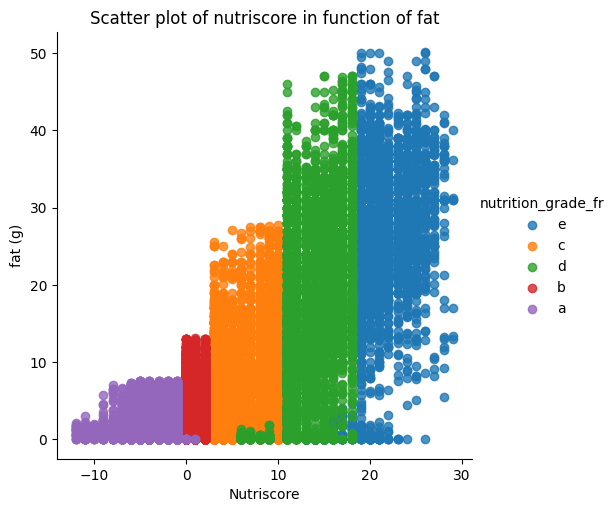

In [66]:
# scatter plot
sns.lmplot(data=clean_data,x="nutrition-score-fr_100g",y='fat_100g',hue="nutrition_grade_fr", fit_reg=False)
plt.title('Scatter plot of nutriscore in function of fat')
plt.xlabel('Nutriscore')
plt.ylabel('fat (g)')
plt.show()

Text(0, 0.5, 'Fat (g)')

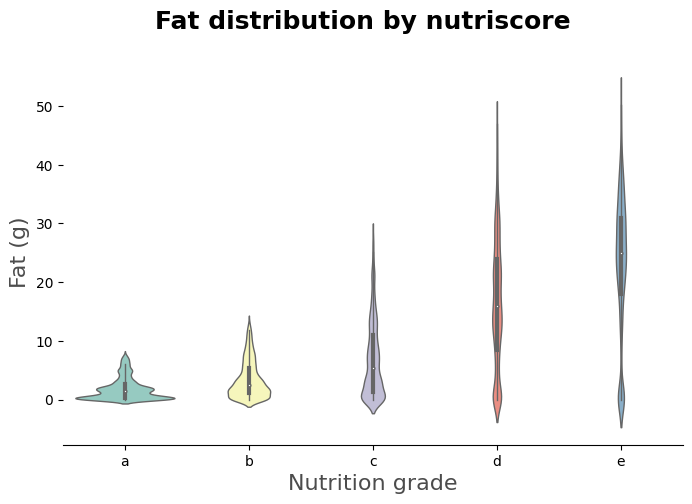

In [67]:
# Violin plot : 
f, ax = plt.subplots(figsize=(8, 5))

# Show each distribution with both violins and points
sns.violinplot(x="nutrition_grade_fr",y="fat_100g",data=clean_data, inner="box",\
     palette="Set3", cut=2, linewidth=1,order=['a','b','c','d','e'])

sns.despine(left=True)

f.suptitle('Fat distribution by nutriscore', fontsize=18, fontweight='bold')
ax.set_xlabel("Nutrition grade",size = 16,alpha=0.7)
ax.set_ylabel("Fat (g)",size = 16,alpha=0.7)

Is is clear that the fat median is different for each nutrition grade. 

Let's see if we can pursue our study with an ANOVA analysis. 


## ANOVA analysis 
### Let's verify ANOVA assumptions which are : 
- fat_100g must have a normal population distribution for each nutriscore level
- each distribution must have the same variance
- data are independent


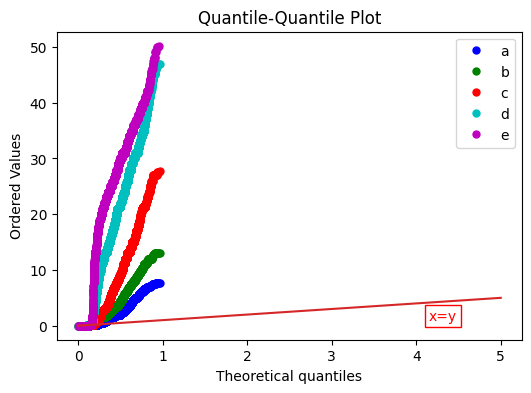

In [68]:

# plt.rcParams["figure.figsize"] = [3.00, 3.00]
i = 0 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
colors=['b','g','r','c','m','y','k','w']
for nutriscore in nutriscores : 
    mask = ( clean_data['nutrition_grade_fr'] == nutriscore ) 
    group = clean_data[mask]["fat_100g"]
    # qqplot (Quantile-Quantile Plot)
    st.probplot(group.values, dist=st.beta, sparams=(2,3), plot=plt, fit=False)
    ax.get_lines()[i].set_label(nutriscore)
    ax.get_lines()[i].set_color(colors[i])
    ax.get_lines()[i].set_markersize(5)
    i = i + 1 
    #sm.qqplot(group, line ='45')

# Add on y=x line
ax.plot([0, 5], [0, 5], c='C3')  
ax.text(0.8,0.1,"x=y",transform=ax.transAxes, fontsize=10, color="red",
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='red', pad=3.0))  
ax.legend()
ax.set_title("Quantile-Quantile Plot")
plt.show()

Each separate group do not have a normal distribution, therefore **the first hypothesis of the ANOVA analysis cannot be validate**. We can not conduct this analysis.

# Multivariate analysis  
## Univariate and bivariate distribution for key variables 

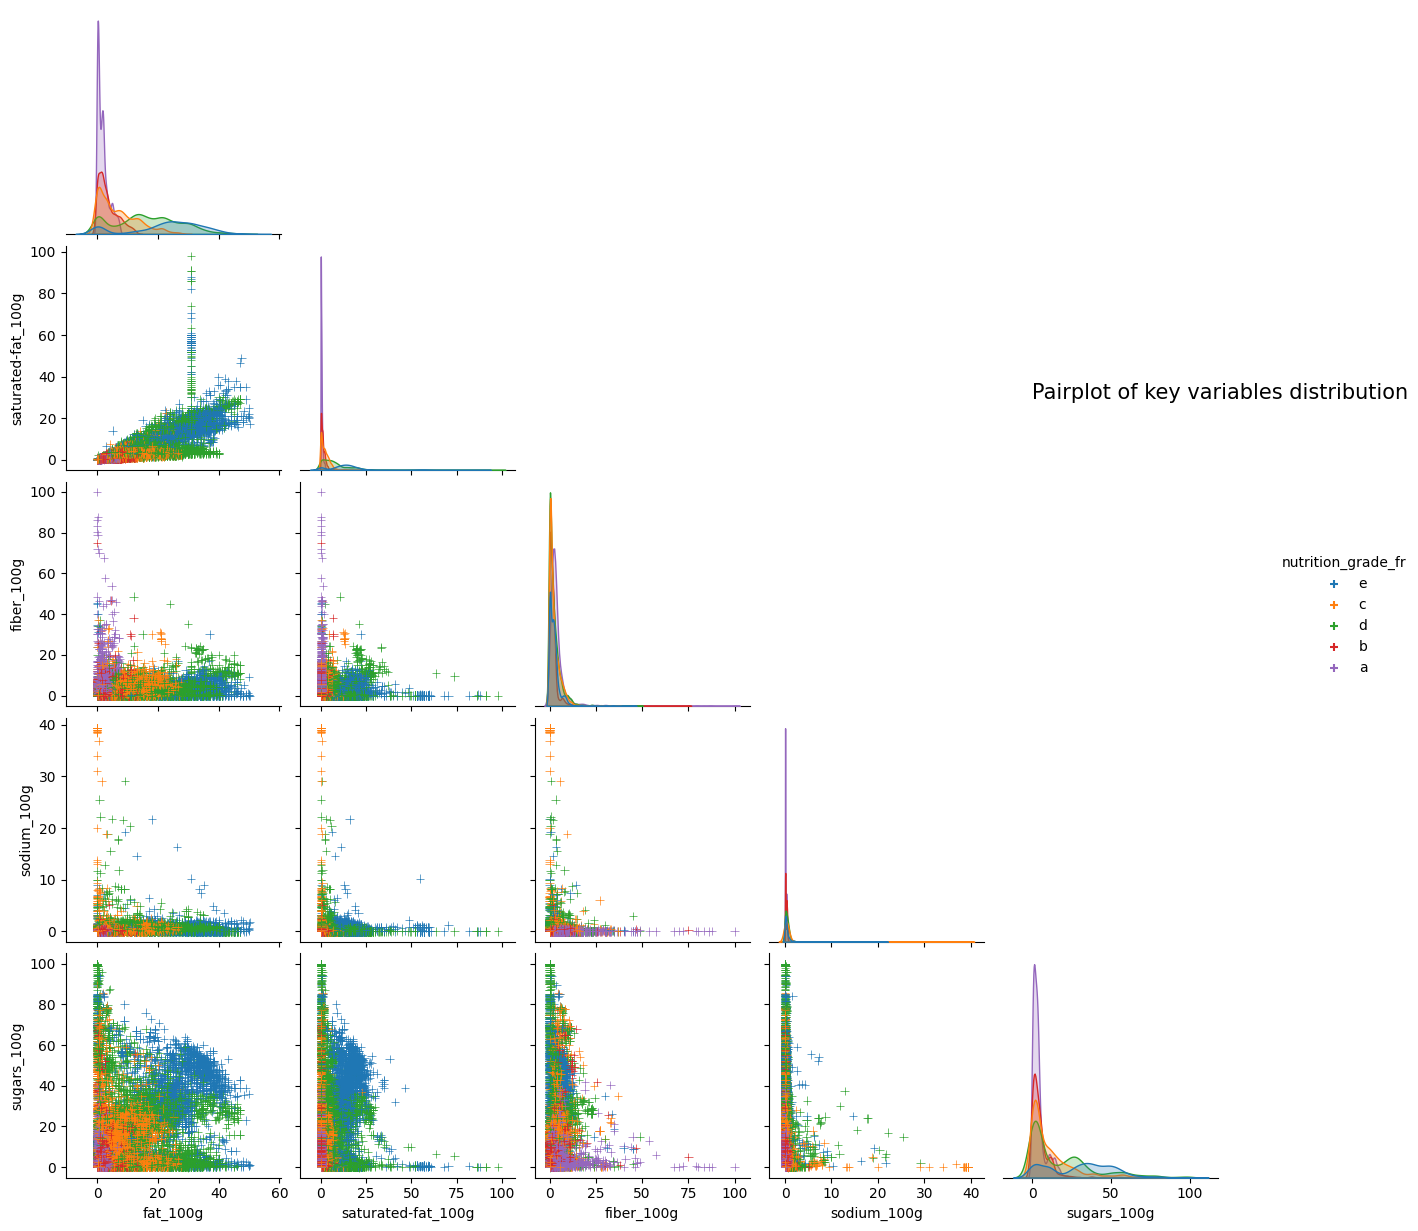

In [69]:
pairplotData = clean_data[['fat_100g','saturated-fat_100g','fiber_100g','sodium_100g', 'sugars_100g','nutrition_grade_fr']]
pPlot = sns.pairplot(pairplotData,hue ='nutrition_grade_fr',markers=["+","+","+","+","+"],corner=True)
plt.show()

Products with high sugar or fat values fat tend to have a lower nutrition grade. It is the same for saturated fat. 

The saturated fat distribution with fat is  below the x=y line as te fat consists of saturated fat and trans-fat. 

However, salt and fiber are less related to the nutriscore grade. 

# Dimension reduction : PCA (Principal component analysis)


In [70]:
# drop non-quantitative variables
eData = clean_data.drop(columns=['additives_n','product_name','nutrition_grade_fr'])

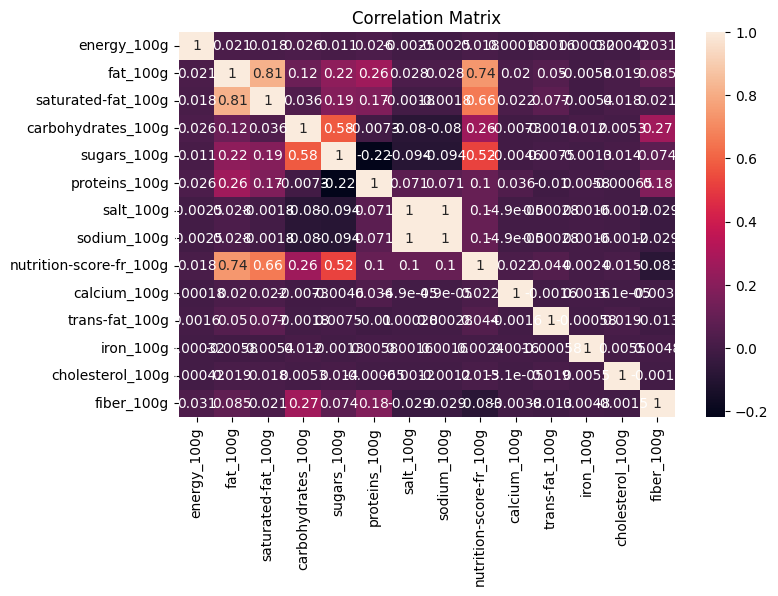

In [71]:
sns.heatmap(eData.corr() , annot=True)
plt.title("Correlation Matrix")
plt.show()

This graph is very interesting here.

First as salt and sodium are linearly correlate, it is expected to have a correlation factor close to 1.

The matrix is symmetric as the the correlation coefficient is a symmetric function. 

The nutriscore is correlated with sugar, fat and saturated fat as indicated in the former pairplot. 

As the data is correlated to some extend it will be intersting to convey a PCA for dimension reduction. 

In [72]:
eData.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,calcium_100g,trans-fat_100g,iron_100g,cholesterol_100g,fiber_100g
count,2.429100e+04,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000,24291.000000
mean,1.201995e+03,9.582800,4.491144,30.401335,12.868695,7.143733,0.927463,0.365143,6.660862,0.144387,0.001971,0.006992,0.000600,2.633174
std,2.086845e+04,10.798323,7.018789,27.540637,17.420128,6.796585,3.497722,1.377071,8.945363,0.510328,0.056901,0.166112,0.070029,3.857240
min,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,-12.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.735000e+02,1.000000,0.210000,5.700000,1.400000,2.000000,0.075000,0.029528,0.000000,0.130000,0.000000,0.005300,0.000000,0.500000
50%,9.880000e+02,4.700000,1.400000,18.000000,4.500000,5.900000,0.508000,0.200000,5.000000,0.130000,0.000000,0.005300,0.000000,1.700000
75%,1.629500e+03,16.000000,5.900000,57.750000,18.000000,9.600000,1.091100,0.429567,14.000000,0.130000,0.000000,0.005300,0.000000,3.400000
max,3.251373e+06,50.200000,98.000000,100.000000,100.000000,86.000000,100.000000,39.370490,29.000000,69.500000,7.140000,25.000000,10.900000,100.000000


The variables distribution are very different even if variable are on the same range between 0 and  1 .

We already noticed this difference with the  pairplot (salt and fat for instance). 

So each variable can have the same weight in the PCA, we will scale our dataset using the **standard scaler**. 

Other methods exist such as **robust** or **min max**, but as the data is cleaned of the majority of outliers and from the same range **standard scaling** is sufficient. 

In [73]:
# normalize each variable so they have the same weight
scaler = StandardScaler()
scaler.fit(eData)
X_scaled = scaler.transform(eData)
X_scaled = scaler.fit_transform(eData)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00,24291.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.06,-0.89,-0.64,-1.10,-0.74,-1.05,-0.27,-0.27,-2.09,-0.28,-0.03,-0.04,-0.01,-0.68
25%,-0.04,-0.79,-0.61,-0.90,-0.66,-0.76,-0.24,-0.24,-0.74,-0.03,-0.03,-0.01,-0.01,-0.55
50%,-0.01,-0.45,-0.44,-0.45,-0.48,-0.18,-0.12,-0.12,-0.19,-0.03,-0.03,-0.01,-0.01,-0.24
75%,0.02,0.59,0.20,0.99,0.29,0.36,0.05,0.05,0.82,-0.03,-0.03,-0.01,-0.01,0.20
max,155.75,3.76,13.32,2.53,5.00,11.60,28.33,28.33,2.50,135.91,125.45,150.46,155.64,25.24


In [74]:
# PCA analysis
n_comp = 8
mypca = PCA(n_components=n_comp)
X_pca = mypca.fit_transform(X_scaled)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
outputPCAData = mypca.fit_transform(X_scaled)

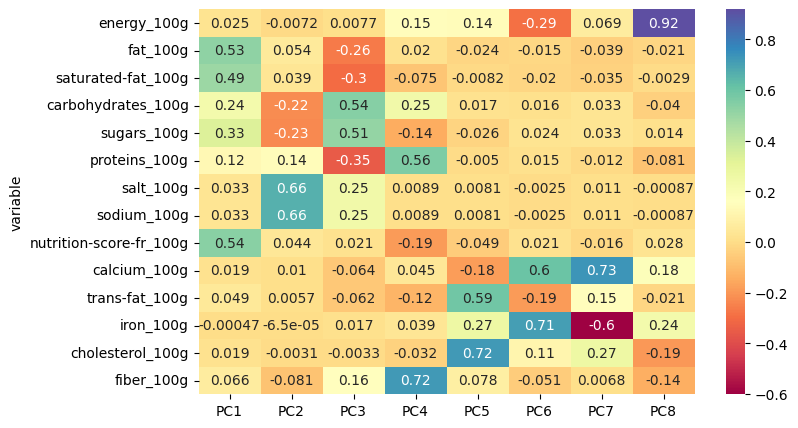

In [75]:
loadings = mypca.components_
num_pc = mypca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = eData.columns.values
loadings_df = loadings_df.set_index('variable')
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.rcParams["figure.figsize"] = [10.00, 4.00] 
plt.show()

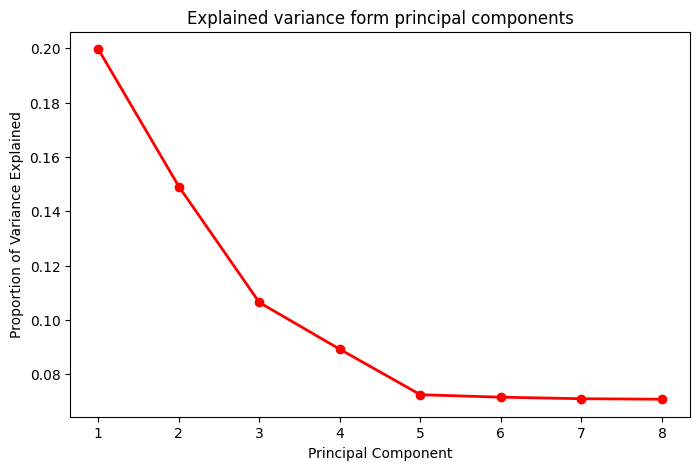

In [76]:
PC_values = np.arange(mypca.n_components_) + 1
plt.rcParams["figure.figsize"] = [8.00, 5.00] 
plt.plot(PC_values, mypca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Explained variance form principal components')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

### Choice of the number of components: 
The Proportion of variance explained shows the percentage of the normalized associated eigenvalue. 
Here we are looking for an **“elbow”** that indicates the drop in information provided by the components. 

This correspond to the fifth component so we will only use **five components** for our application.
The ACP allows a size reduction from 14 to 5.


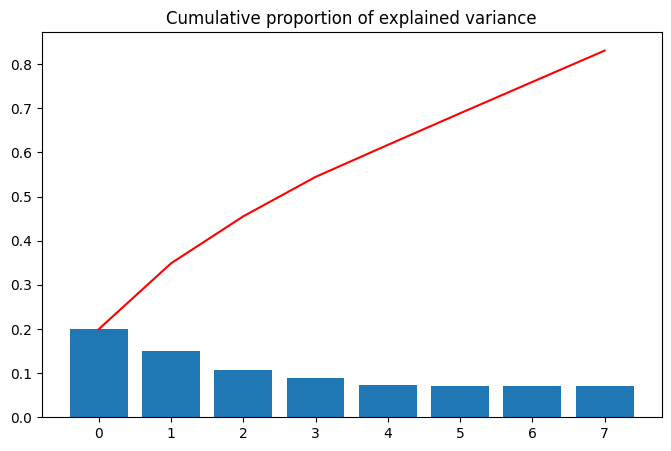

In [77]:
# Pareto diagram
y = list(mypca.explained_variance_ratio_)
x = range(len(y))
ycum = np.cumsum(y)
plt.bar(x,y)
plt.plot(x,ycum,"-r")
plt.rcParams["figure.figsize"] = [20.00, 8.00] 
plt.title("Cumulative proportion of explained variance")
plt.show()

Taking five components result in 70% of explained variance which we consider to be enough. 

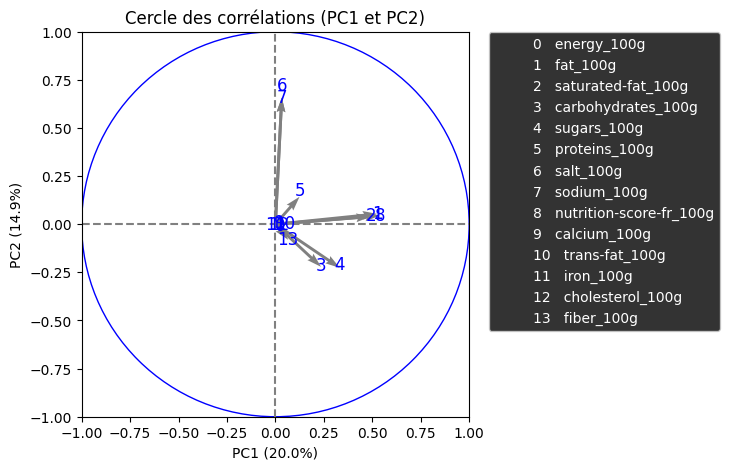

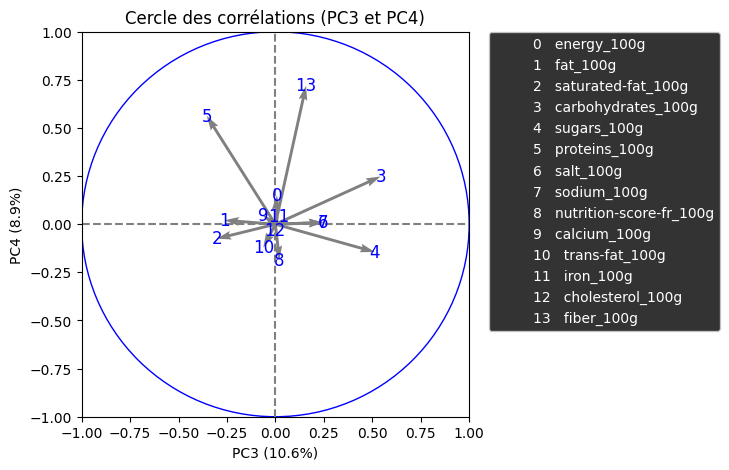

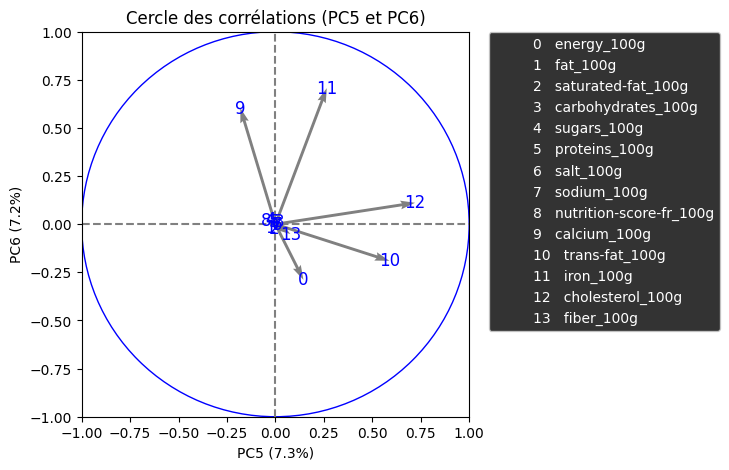

In [78]:
import sys
sys.path.append('../tools/')
from pca_fn import display_circles
display_circles(mypca.components_,n_comp, mypca, [(0,1),(2,3),(4,5)],labels =eData.columns.values)

## Visualization  of Principal Components distribution
Outliers removal and normalization

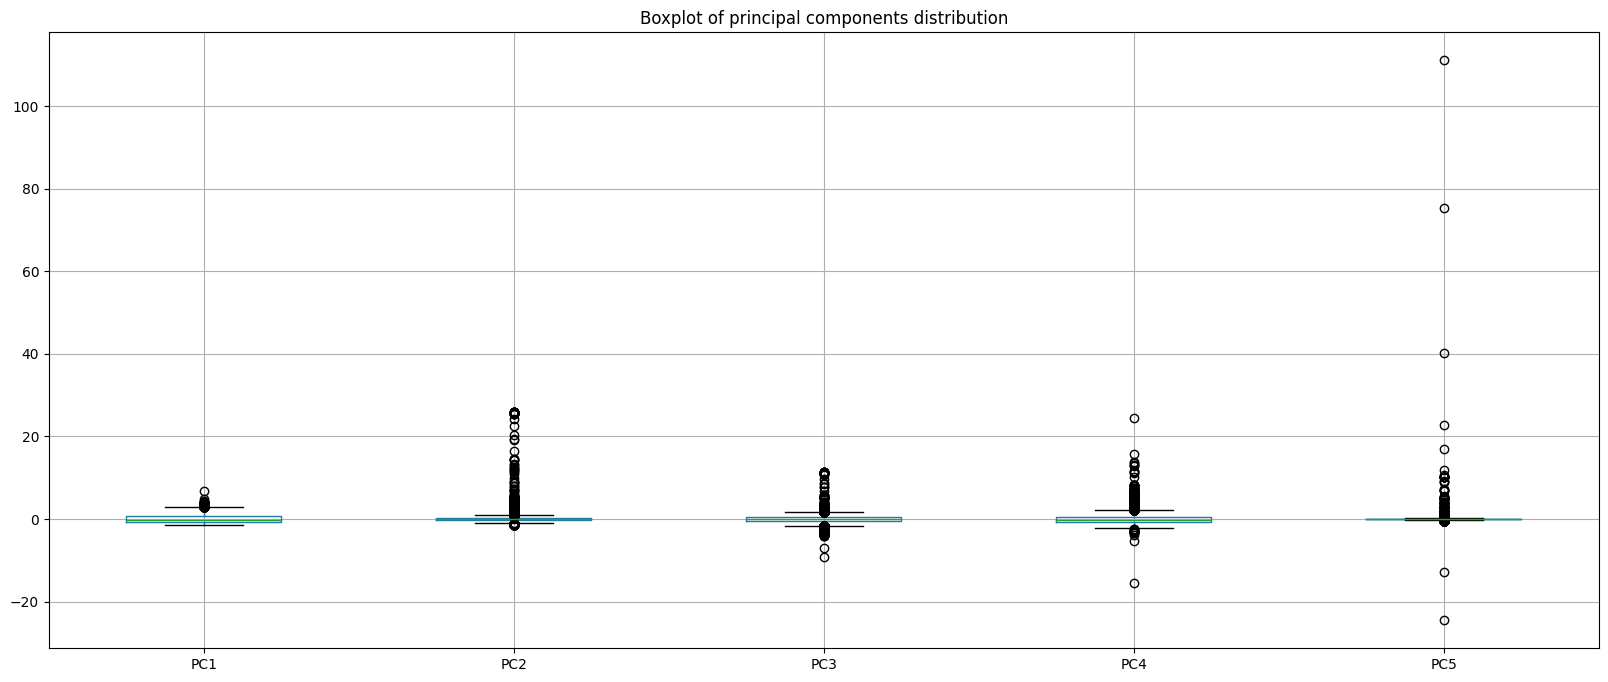

In [79]:
PCs = ['PC1','PC2','PC3','PC4','PC5']
# normalize each PCs
for p in PCs : 
    X_pca[p]=(X_pca[p]-X_pca[p].mean())/X_pca[p].std()

X_pca[PCs].boxplot()
plt.title('Boxplot of principal components distribution')
plt.show()


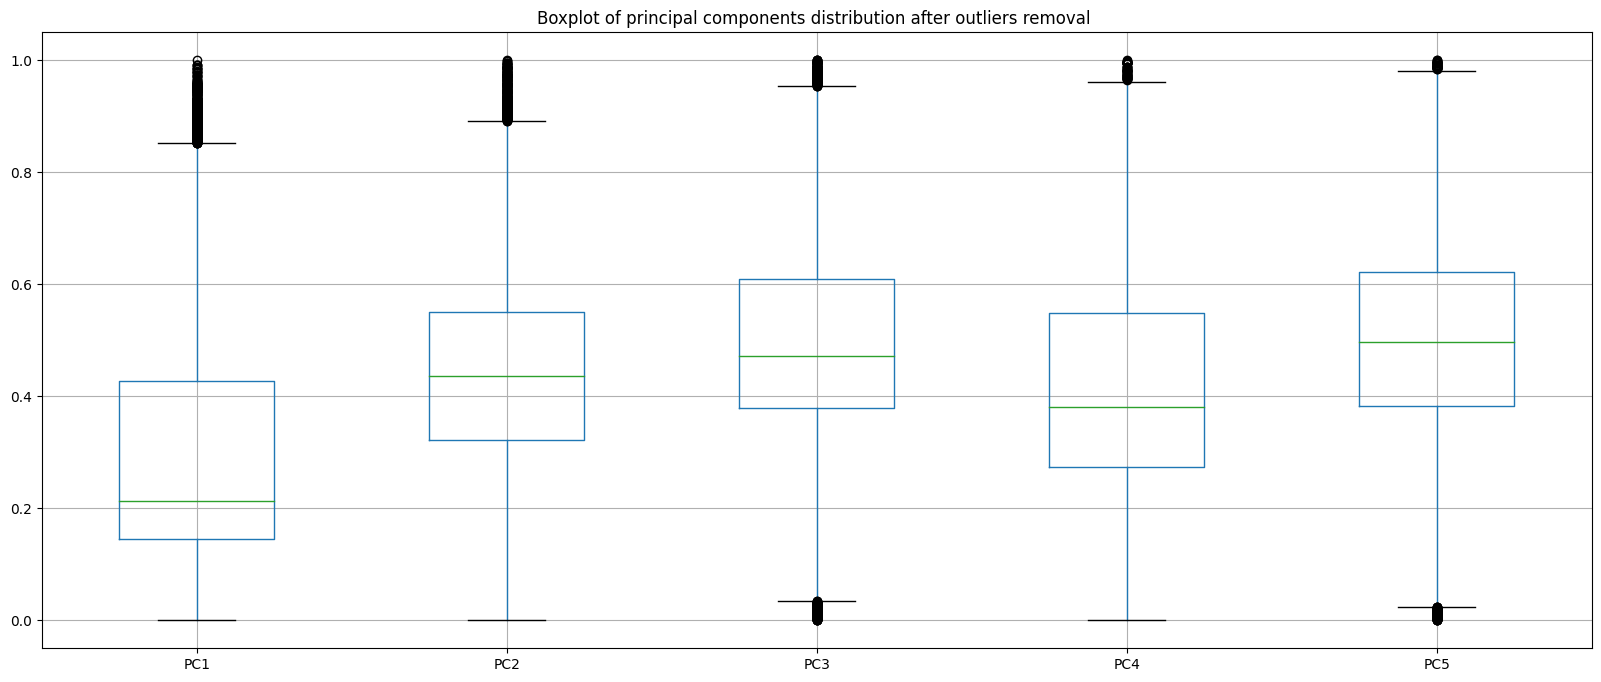

In [80]:
# remove outliers : 

for p in PCs : 
    Q3 = np.quantile(X_pca[p], 0.75)
    Q1 = np.quantile(X_pca[p], 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    mask = (X_pca[p] < lower_range)  | ( X_pca[p] > upper_range )
    X_pca.drop(X_pca.loc[mask].index, inplace=True)
# normalize each PCs
for p in PCs : 
    X_pca[p]=(X_pca[p]-X_pca[p].min())/(X_pca[p].max()-X_pca[p].min())
    
X_pca[PCs].boxplot()
plt.title('Boxplot of principal components distribution after outliers removal ')
plt.show()


## The table and correlation circle analysis 
We only consider the first five principal components (PCs): 
- first  one : positively correlate with fat, saturated-fat and also sugar and carbohydrates
- second one : positively correlate with salt and sodium 
- third  one : positively correlate with sugar and carbohydrate **but negatively** with proteins
- fourth one : positively correlate with to fiber and proteins 
- fifth  one : positively correlate with saturated fat and cholesterol . 

Let's rename each PCs: 

- **1 -> atherosclerosis**  ("hardening of the arteries") factor
- **2 -> heart failure and high blood pressure** factor
- **3 -> diabetes** factor
- **4 -> prevention** factor (beneficial for heart issue)
- **5 -> raise level of non-HDL** (bad cholesterol)
So 1,2,3 and 5 should be consider negatively and 4 positively for our product recommendation.

I attribute a weight to each component  to rank our products. Taking into account whether is has a benefit or a damage impact on the health. 

I aldo decided to take into account the number of additives present in each product which is not present in the PCA. 

For more specified newsletters, for instance focusing on diabetes, it may be relevant to add a larger weight for the relevant component. 

In [81]:
# Join PCA and cleaned dataset 
merged_df = clean_data.merge(X_pca, left_index=True,
                       right_index=True, suffixes=['_', ''])

# Explainability : each PC explained weighted for futur score 
merged_df['atherosclerosis']                        = - merged_df['PC1']
merged_df["heart_failure_and_high_blood_pressure"]  = - merged_df['PC2']
merged_df["diabetes"]                               = - merged_df['PC3']
merged_df["prevention"]                             =  4*merged_df['PC4']
merged_df["bad_cholesterol"]                        = - merged_df['PC5']

# Transform product with a lot of additives are harmful for the heart, we take this into account by creating a additives_score
merged_df["additives_score"] = - 2* ( merged_df["additives_n"]-merged_df["additives_n"].min())/(merged_df["additives_n"].max()-merged_df["additives_n"].min() )

## First five recommended products : 

In [82]:
ListofFactors = ['atherosclerosis','heart_failure_and_high_blood_pressure','diabetes','prevention','bad_cholesterol',"additives_score"]

# Heart score calculation 
merged_df['heart_score']= merged_df[ListofFactors].sum(axis=1)  

# linear transformation to [0,1]
merged_df['heart_score'] = ( merged_df['heart_score'] + 6 ) / 10 

# Select product with highest score 
Scores = merged_df.sort_values('heart_score',ascending=False)

Scores[['product_name','heart_score']].head()


,product_name,heart_score
13298,Quenelles de brochet sauce Nantua,0.844833
13299,Coquilles Saint-Jacques* à la Bretonne (4 + 2 ...,0.844833
13682,2 Clafoutis aux tomates et aux fromages de chè...,0.833847
13693,4 Mini-gratins de pomme de terre,0.832561
4902,Laitue iceberg,0.823949
